In [5]:
import numpy as np
import sys, os
import matplotlib.pyplot as plt
sys.path.append(os.path.realpath('..'))
import pandas as pd

from hyppo.independence import Dcorr, HHG
from hyppo.ksample import KSample
from hyppo.sims import spiral, rot_2samp

In [6]:
N = 100

tests = [
    HHG,
    Dcorr,
    KSample,
]

In [9]:
for i in range(N):
    x, y = spiral(500, 1, noise=True)
    sim = np.hstack([x, y])
    np.savetxt('../benchmarks/same_stat/indep/{}.csv'.format(i+1), sim, delimiter=',')
    sim1, sim2 = rot_2samp(spiral, 500, 1, noise=True)
    np.savetxt('../benchmarks/same_stat/ksample/sim1_{}.csv'.format(i+1), sim, delimiter=',')
    np.savetxt('../benchmarks/same_stat/ksample/sim2_{}.csv'.format(i+1), sim, delimiter=',')

In [10]:
for test in tests:
    stats = []
    for i in range(N):
        if test.__name__ == "KSample":
            sim1 = np.genfromtxt('../benchmarks/same_stat/ksample/sim1_{}.csv'.format(i+1), delimiter=',')
            sim2 = np.genfromtxt('../benchmarks/same_stat/ksample/sim2_{}.csv'.format(i+1), delimiter=',')
            stat = KSample(indep_test="Hsic", bias=True)._statistic(sim1, sim2)
        else:
            sim = np.genfromtxt('../benchmarks/same_stat/indep/{}.csv'.format(i+1), delimiter=',')
            x, y = np.hsplit(sim, 2)
            stat = test()._statistic(x, y)
        stats.append(stat)
    np.savetxt('../benchmarks/same_stat/{}.csv'.format(test.__name__), stats, delimiter=',')

In [11]:
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:])

In [50]:
import matplotlib.ticker as mticker


FONTSIZE = 20


def plot_stats():
    fig = plt.figure(figsize=(5,7))
    ax = plt.subplot(111)
    
    test_names = [
        "Dcorr",
        "MMD",
        "HHG"
    ]
    
    data = np.zeros((N, len(test_names)))
    for i in range(len(test_names)):
        if test_names[i] == "MMD":
            mgc_stat = np.genfromtxt('../benchmarks/same_stat/KSample.csv', delimiter=',')
            r_stat = np.genfromtxt('../benchmarks/same_stat/RMMD.csv', delimiter=',')
            mgc_stat = mgc_stat / (2 * 0.05) * (500 * 2) # exact equivalence stat correction
        else:
            mgc_stat = np.genfromtxt('../benchmarks/same_stat/{}.csv'.format(test_names[i]), delimiter=',')
            r_stat = np.genfromtxt('../benchmarks/same_stat/R{}.csv'.format(test_names[i]), delimiter=',')
            if test_names[i] == "HHG": # Fix for large HHG stats so difference is comparable
                mgc_stat *= 1e-8
                r_stat *= 1e-8
        data[:, i] = np.abs(mgc_stat) - np.abs(r_stat)
    
    data = pd.DataFrame(data=data, columns=test_names)
    #sns.violinplot(data=data, inner=None)
    sns.stripplot(data=data, edgecolor="gray", size=5, palette=["#377eb8", "#ff7f00", "#4daf4a"], jitter=1)
    ax.axhline(y = 0, color='red', linewidth=1)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    #ax.text(-1.1, 0, "Test Statistic Difference", va='center', rotation='vertical')
    ax.set_ylabel("Test Statistic\nDifference")
    ax.set_ylim(-5e-4, 5e-4)
    ax.set_yticks([-5e-4, 0, 5e-4])
    f = mticker.ScalarFormatter(useOffset=False)
    g = lambda x, pos : "{}".format(f._formatSciNotation('%1.1e' % x))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(g))
    
    plt.savefig('../benchmarks/figs/same_stat.pdf', transparent=True, bbox_inches='tight')

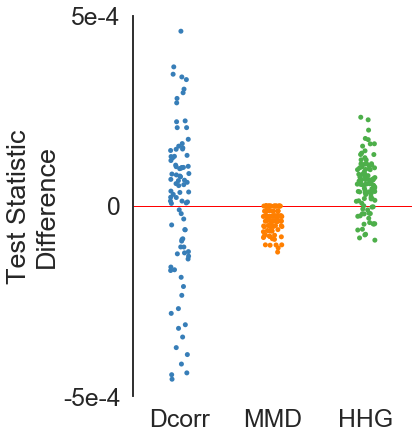

In [51]:
plot_stats()